In [33]:
import numpy as np

def football(nchain, data, gamma_prior, init, prop_sd,
             burnin = 1000, thin = 10):
    ## Fais un M.-H. pour le modèle Poissonien (Exo 7)
    ## C'est débile car on connait la loi a posteriori en vrai
    
    acc_rate = 0
    ngoals = np.sum(data)##nombre de buts total
    ngames = len(data)##nombre de matches joués
    chain = np.zeros(nchain)

    current = init
    index = 0
    t = 0

    while index < nchain:
        ## Générons un candidat via marche aléatoire à l'échelle log
        prop = np.random.lognormal(np.log(current), prop_sd)

        ## Proba d'acceptation
        top = (gamma_prior[0] + ngoals - 1) * np.log(prop) - prop * (gamma_prior[1] + ngames)
        bottom = (gamma_prior[0] + ngoals - 1) * np.log(current) - current * (gamma_prior[1] + ngames)

        acc_prob = np.exp(top - bottom) * prop / current

        ## Mise à jour de la chaine
        if np.random.uniform() < acc_prob:
            current = prop
            acc_rate += 1
        
        if ((t > burnin) and (t % thin == 0)):
            chain[index] = current
            index += 1
        
        t += 1

    
    return chain, acc_rate / nchain




In [34]:
## Application 
url = "https://www.football-data.co.uk/mmz4281/2425/F1.csv"

import pandas as pd
data = pd.read_csv(url)
data

## On choisit les matchs d'une équipe en particulier
team = "Paris SG"

home_goals = data["FTHG"][data["HomeTeam"] == team]
away_goals = data["FTAG"][data["AwayTeam"] == team]
all_goals = np.concatenate((home_goals, away_goals))
all_goals.shape



(20,)

In [46]:
nchain = 10**4
gamma_prior = [1, 0.5]##espérance 2 et variance 4 (assez diffuse)
init = np.mean(all_goals)
prop_sd = 0.5

chain, acc_rate = football(nchain, all_goals, gamma_prior, init, prop_sd)

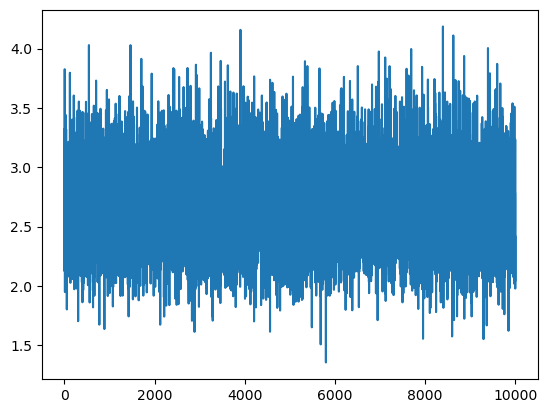

In [47]:
import matplotlib.pyplot as plt
plt.plot(chain)

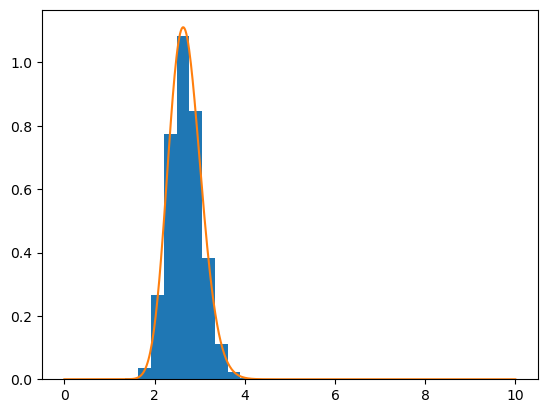

In [48]:
## Ma chaine mélange super bien je suis content

import scipy.stats as stats
plt.hist(chain, density=True)
x = np.linspace(0, 10, 500)
y = stats.gamma.pdf(x, gamma_prior[0] + np.sum(all_goals), scale = 1 / (len(all_goals) + gamma_prior[1]))
plt.plot(x, y)
## On voit bien que mon code marche bien car il reproduit la densité a posteriori théorique

In [50]:
## Estimation ponctuelle par moyenne a posteriori
print(np.mean(chain))

## Intervalle de crédibilité à 95\‰
print(np.quantile(chain, [0.025, 0.975]))

2.6805703249175523
[2.02564251 3.43219582]


La loi prédictive est donnée par
\begin{align*}
\pi(n_* \mid n_1, \ldots, n_n) &= \int f(x_* \mid n_1, \ldots, n_n, \lambda) \pi(\lambda \mid n_1, \ldots, n_n) d\lambda\\
 &= \int f(x_* \mid \lambda) \pi(\lambda \mid n_1, \ldots, n_n) d\lambda
 \end{align*}

On pourrait faire une prédiction du nombre de buts marqués par notre équipe via (par exemple) la moyenne de cette loi prédictive a posteriori. Cela se fait très simplement grâce à notre chaine de Markov...

In [52]:
pred = np.random.poisson(chain, size = nchain)
print(np.mean(pred))
print(np.quantile(pred, [0.025, 0.975]))

2.6972
[0. 6.]


Text(0, 0.5, 'Probability mass function')

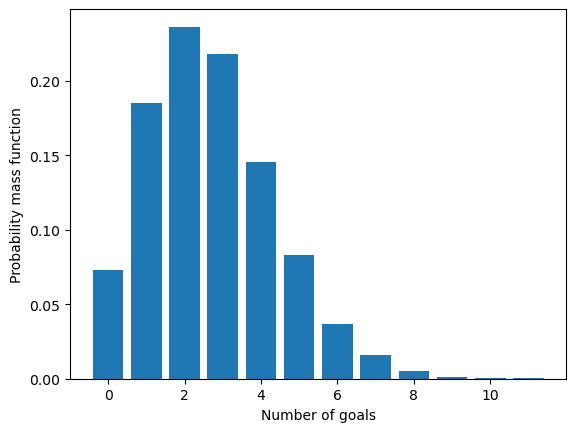

In [77]:
import pandas as pd
emp_prob = pd.value_counts(pred, sort = False, ascending=True, normalize=True)
plt.bar(x = emp_prob.index, height = emp_prob)
plt.xlabel("Number of goals")
plt.ylabel("Probability mass function")